## Importing Modules :

In [1]:
import jax
# print(jax.__version__)

In [2]:
# installing optax and flax in colab! for optimization
from jax import config
config.update("jax_enable_x64", True)  #double precision


In [3]:
import jax.numpy as jnp
import json
import os
import sys
from skopt.space import Space
from skopt.sampler import Halton
from jax import jacfwd

# Special Transform Functions
from jax import grad, jit, vmap, pmap
import jax
from jax import jit

from jax._src.lax.utils import (
    _argnum_weak_type,
    _input_dtype,
    standard_primitive,)
from jax._src.lax import lax

from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import prk_method.prk_for_optimization as IRK4
import Important_functions.Transformation_Functions as TFunctions
import Important_functions.Convert_1D2D as convert
import Important_functions.Energy_Error as EE


# Functions :

In [4]:
"""
 : using the initial matrix A and B from the source given below :
 : wiki link : https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods#:~:text=is%5B13%5D-,0,1/6,-A%20slight%20variation
"""

"""
############################### Original ##########################################
"""
## Lobatto 3A and B fourth order

A1 = A2 = jnp.array([
     [0., 0., 0., 0.],
     [5/24, 1/3, -1/24, 0.],
     [1/6, 2/3, 1/6, 0.],
     [0., 0., 0., 0.]])
B1 = B2 = jnp.array([1/6, 2/3, 1/6, 0.])

"""
####################################### Perturbed #######################################
"""
# A1 = jnp.array([
#      [0., 1., 0., 0.],
#      [13/24, 3., -1., 0.],
#      [7/6, 2., 13/6, 0.],
#      [0., 0., 0., 0.]])
# B1 = jnp.array([1/2, 2., 1., 0.])


# # Lobatto IIIB fourth-order
# A2 = jnp.array([
#      [1/6, -1/6, 0., 0.],
#      [1/6, 1/3, 0., 0.],
#      [1/6, 5/6, 0., 0.],
#      [0., 0., 0., 0.]])
# B2 = jnp.array([1/6, 2/3, 1/6, 0.])
"""
#################################### Perturbed Finished #######################################
"""


## Making the Halton code

spacedim = [(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5) ]

space = Space(spacedim)

halton = Halton()
n = 150

halton_sequence = halton.generate(space, n)
halton_sequence = jnp.array(halton_sequence)

## Dividing in training and validation set. 100 for the training set and 50 for the validation set. 
validation_halton = halton_sequence[100:150]
halton_sequence = halton_sequence[:100]
print(halton_sequence)

# print(len(halton_sequence))
# print(len(validaton_halton))



[[-1.         -1.         -1.         -1.         -1.         -1.        ]
 [-0.25       -0.5        -0.7        -0.78571429 -0.86363636 -0.88461538]
 [-0.625       0.         -0.4        -0.57142857 -0.72727273 -0.76923077]
 [ 0.125      -0.83333333 -0.1        -0.35714286 -0.59090909 -0.65384615]
 [-0.8125     -0.33333333  0.2        -0.14285714 -0.45454545 -0.53846154]
 [-0.0625      0.16666667 -0.94        0.07142857 -0.31818182 -0.42307692]
 [-0.4375     -0.66666667 -0.64        0.28571429 -0.18181818 -0.30769231]
 [ 0.3125     -0.16666667 -0.34       -0.96938776 -0.04545455 -0.19230769]
 [-0.90625     0.33333333 -0.04       -0.75510204  0.09090909 -0.07692308]
 [-0.15625    -0.94444444  0.26       -0.54081633  0.22727273  0.03846154]
 [-0.53125    -0.44444444 -0.88       -0.32653061  0.36363636  0.15384615]
 [ 0.21875     0.05555556 -0.58       -0.1122449  -0.98760331  0.26923077]
 [-0.71875    -0.77777778 -0.28        0.10204082 -0.85123967  0.38461538]
 [ 0.03125    -0.27777778

## ADAgrad using optax

In [5]:
# Initial A1D
import optax

A1D = convert.Convert_toOneD(A1, A2, B1, B2)
print(A1D.shape)

learning_rate = 0.0001
list_optimizers = [optax.sgd(learning_rate)]
# chosing Stochastic Gradient Descent Algorithm.
# # We have created a list here keeping in mind that we may apply all the optimizers in optax by storing their objects in the list
 
opt_sgd = list_optimizers[0]
opt_state = opt_sgd.init(A1D)

params = A1D

count = 0
data_epoc = 10
data_epoc_list = []
repetetion = 10
# length of halton sequence = 10 

tot_eror = 0
error_list_1 = [] 
error_list_2 = []
error_list_3 = [] # For Energy Error 
error_list_4 = [] # For Error 

flat_halton_sequence = jnp.array(halton_sequence).reshape(-1, 6)

## Batch Size
batch_size = 100 ## just to remind you right now total halton sequence is also 100, so we are taking the whole set as the batch.
validation_batch_size = 50
# print(halton_sequence)
# print(len(flat_halton_sequence)) 
# print(flat_halton_sequence)
# print(batch_size)

directory = 'Recorded_Results_SGD2'
file_path1 = os.path.join(directory, 'output.txt')
# Open the file in write mode to clear it
with open(file_path1, 'w') as file:
    pass  # This does nothing, but it's enough to clear the file

file_path2 = os.path.join(directory, 'Step_error.txt')
# Open the file in write mode to clear it
with open(file_path2, 'w') as file:
    pass  # This does nothing, but it's enough to clear the file


def compute_grads_single(A1D, h_element):
    grad_fn = jax.jacfwd(IRK4.find_error)
    return grad_fn(A1D, h_element)

def compute_error_single(A1D, h_element):
    return IRK4.find_error(A1D, h_element)

def append_to_summary(k, avg_error):
    file_path = os.path.join(directory, f'Step_error.txt')
    
    # # Define the file name
    # file_name = '0_summary_sgd2.txt'

    # Append the data to the text file
    with open(file_path, 'a') as file:
        file.write(f'{k} : {avg_error}\n')
        
## Finding the numeric gradient. Jacfwd is not showing good results. 
def numerical_gradient(A1D, halton_element, epsilon=1e-5):
    numerical_gradients = jnp.zeros_like(A1D)

    for i in range(len(A1D)):
        A1D_plus = A1D.at[i].set(A1D[i] + epsilon)
        A1D_minus = A1D.at[i].set(A1D[i] - epsilon)
        numerical_gradients = numerical_gradients.at[i].set(
            (compute_error_single(A1D_plus, halton_element) - compute_error_single(A1D_minus, halton_element)) / (2 * epsilon)
        )

    return numerical_gradients

# Use jax.vmap to vectorize the function over the batch
compute_grads_batched = jax.vmap(numerical_gradient, in_axes=(None, 0)) # using the numerical gradient instead of jacfwd()
compute_error_batched = jax.vmap(compute_error_single, in_axes=(None, 0))

error_list_1 = [] 
error_list_2 = []
error_list_3 = [] # Energy Error :
error_list_4 = [] # Error :
validation_error_list = []
tot_error = 0
tot_error_energy = 0
total_error_e = 0
validation_tot_error = 0
validation_avg_error = 0

for k in trange(1000):
    tot_error = 0
    validation_tot_error = 0
    for batch_idx in range(0, len(flat_halton_sequence), batch_size):
        
        # print("#####", batch_idx)
        # print("#####")
        # print("#####")
        # print("#####")
        
        # Collect a batch of elements from the flattened Halton sequence
        batch_halton = flat_halton_sequence[batch_idx:batch_idx + batch_size]

        # Compute the gradients for the batch using jax.vmap
        gradF = compute_grads_batched(A1D, batch_halton)

        # Compute the average gradient for the batch
        avg_gradF = jnp.mean(gradF, axis=0)

        # Perform one step of optimization using the averaged gradient
        updates, opt_state = opt_sgd.update(avg_gradF, opt_state)

        # Apply the updates to the weights A1D for the entire batch
        A1D = optax.apply_updates(A1D, updates)

        # Calculate the total error for the batch and accumulate it
        batch_error = jnp.mean(compute_error_batched(A1D, batch_halton))
        tot_error += batch_error
    """
    # what am i tying to do here ?
    """
    avg_error = tot_error / (len(flat_halton_sequence) // batch_size) # ?
    error_list_1.append(avg_error) # ?
  
    # tot_error = 0
    # for mm in range(len(halton_sequence)):
    #     tot_error += IRK4.find_error(A1D, halton_sequence[mm])
    
    # avg_error = tot_error / len(halton_sequence)
    # error_list_2.append(avg_error)
    
    # """
    # ################# Energy Error Calculation : ###################
    # """
    # for mm in range(len(halton_sequence)):
    #     energy_e = EE.find_error(A1D, halton_sequence[mm])
    #     total_error_e += energy_e[0]
    #     tot_error_energy += energy_e[1]
    
    # avg_error_energy = tot_error_energy / len(halton_sequence)
    # error_list_3.append(avg_error_energy) ## Energy error Average
    
    # avg_error_e = total_error_e / len(halton_sequence)
    # error_list_4.append(avg_error_e)
    # """
    # ################################################################
    # """ 
    
    # # Validation data set
    # for mm in range(0,len(validation_halton)):
    #     validation_tot_error += IRK4.find_error(A1D, validation_halton[mm])
    
    # validation_avg_error = validation_tot_error / len(validation_halton)
    # validation_error_list.append(validation_avg_error)
    
    # A1D = A1D[:40]
    
    # new_A1, new_A2, new_B1, new_B2 = convert.Convert_toTwoD(A1D)
    
    # # Create a directory if it doesn't exist
    # directory = 'Recorded_Results_SGD2'
    
    # # Define the file path based on the value of k
    # file_path = os.path.join(directory, f'BatchOutput_SGD2.json')
    
    # if not os.path.exists(directory):
    #     os.makedirs(directory)
    
    # # Saving to a json file.
    # json_A1 = new_A1.tolist()
    # json_A2 = new_A2.tolist()
    # json_B1 = new_B1.tolist()
    # json_B2 = new_B2.tolist()
    # json_avg_error = float(avg_error)
    # # Combine data into a dictionary
    # data = {
    #     'Number' : k,
    #     'Error' : json_avg_error,
    #     'A1': json_A1,
    #     'A2': json_A2,
    #     'B1': json_B1,
    #     'B2': json_B2 
    # }
    
    # try:
    #     with open(file_path, 'r') as file:
    #         existing_data = json.load(file)
    # except FileNotFoundError:
    #     existing_data = []

    # existing_data.update(data)
    
    # # Save the data to BatchOutput.json
    # with open(file_path, 'w') as file:
    #     json.dump(existing_data, file)

    # # print(f'Data saved to {file_path}')
    
    # ###
    
    # """Creating new files for all the new A1, A2, B1 and B2 values"""
    
    # # Assuming you have the necessary data (new_A1, new_A2, new_B1, new_B2, avg_error, k)

    # # Convert lists to strings
    # A1_str = ' - '.join(map(str, new_A1.tolist()))
    # A2_str = ' - '.join(map(str, new_A2.tolist()))
    # B1_str = ' - '.join(map(str, new_B1.tolist()))
    # B2_str = ' - '.join(map(str, new_B2.tolist()))

    # # Convert avg_error to a float (if necessary)
    # avg_error_float = float(avg_error) if avg_error.shape == () else avg_error.tolist()

    # # Convert k to an integer (if it's not already)
    # json_k = int(k)

    
    # # Define the file path based on the value of k
    # file_path = os.path.join(directory, f'output.txt')
    
    # if not os.path.exists(directory):
    #     os.makedirs(directory)
        
    # # Read existing content (if any)
    # try:
    #     with open(file_path, 'r') as file:
    #         existing_content = file.read()
    # except FileNotFoundError:
    #     existing_content = ''


    # # Write the data to the text file
    # with open(file_path, 'w') as file:
    #     file.write(existing_content)
    #     file.write(f'Number: {json_k}\n')
    #     file.write(f'Error: {avg_error_float}\n')
    #     file.write(f'A1: {A1_str}\n')
    #     file.write(f'A2: {A2_str}\n')
    #     file.write(f'B1: {B1_str}\n')
    #     file.write(f'B2: {B2_str}\n')
    #     file.write('-' * 80 + '\n')  # Add a division line
    
    # """Creating a single file for sequence number and error associated with it. """
    # append_to_summary(k, avg_error_float)
    
    

(40,)


100%|██████████| 1000/1000 [31:27<00:00,  1.89s/it]


In [13]:
print(error_list_1)

[Array(2.93145702e-12, dtype=float64), Array(2.92207057e-12, dtype=float64), Array(2.91547522e-12, dtype=float64), Array(2.91108971e-12, dtype=float64), Array(2.90823863e-12, dtype=float64), Array(2.9065759e-12, dtype=float64), Array(2.9058196e-12, dtype=float64), Array(2.90569889e-12, dtype=float64), Array(2.90598832e-12, dtype=float64), Array(2.9066504e-12, dtype=float64), Array(2.90747663e-12, dtype=float64), Array(2.90838622e-12, dtype=float64), Array(2.90935748e-12, dtype=float64), Array(2.91031115e-12, dtype=float64), Array(2.9112203e-12, dtype=float64), Array(2.91209811e-12, dtype=float64), Array(2.91292758e-12, dtype=float64), Array(2.91367609e-12, dtype=float64), Array(2.91434643e-12, dtype=float64), Array(2.91489243e-12, dtype=float64), Array(2.91543019e-12, dtype=float64), Array(2.91589317e-12, dtype=float64), Array(2.91623826e-12, dtype=float64), Array(2.9165404e-12, dtype=float64), Array(2.91680379e-12, dtype=float64), Array(2.91700163e-12, dtype=float64), Array(2.91714015

In [81]:
print(error_list_2[::-1])
print(len(error_list_2))
print(len(error_list_1))

[]
0
100


In [82]:
print(len(error_list_1))
print(error_list_1)

100
[Array(9.23450231e-08, dtype=float64), Array(4.29436646e-07, dtype=float64), Array(8.72393234e-08, dtype=float64), Array(4.32429334e-07, dtype=float64), Array(8.59343931e-08, dtype=float64), Array(4.33453755e-07, dtype=float64), Array(8.46296495e-08, dtype=float64), Array(4.3447801e-07, dtype=float64), Array(8.3325091e-08, dtype=float64), Array(4.35671261e-07, dtype=float64), Array(8.33237233e-08, dtype=float64), Array(4.35672628e-07, dtype=float64), Array(8.33223559e-08, dtype=float64), Array(4.35673995e-07, dtype=float64), Array(8.33209893e-08, dtype=float64), Array(4.35675362e-07, dtype=float64), Array(8.33196218e-08, dtype=float64), Array(4.35676729e-07, dtype=float64), Array(8.33182546e-08, dtype=float64), Array(4.35678096e-07, dtype=float64), Array(8.33168874e-08, dtype=float64), Array(4.35679463e-07, dtype=float64), Array(8.33155204e-08, dtype=float64), Array(4.3568083e-07, dtype=float64), Array(8.33141536e-08, dtype=float64), Array(4.35682197e-07, dtype=float64), Array(8.33

In [83]:
## Energy error :

print(error_list_3)

[]


# Loading the data from the Json File

In [84]:
# import json
# import jax.numpy as jnp

# # File path
# file_path = 'BatchOutput_SGD2.json'

# # Reading the data from the JSON file
# with open(file_path, 'r') as json_file:
#     loaded_data = json.load(json_file)

# # Converting the data back to jax.numpy
# loaded_A1 = jnp.array(loaded_data['A1'])
# loaded_A2 = jnp.array(loaded_data['A2'])
# loaded_B1 = jnp.array(loaded_data['B1'])
# loaded_B2 = jnp.array(loaded_data['B2'])

# print("upadated A1 : \n", loaded_A1, "\n")
# print("upadated A2 : \n", loaded_A2, "\n")
# print("upadated B1 : \n", loaded_B1, "\n")
# print("upadated B2 : \n", loaded_B2, "\n")

# Tests

In [85]:
# import tests

# test_func = [ tests.F, tests.FyF, tests.FzG, tests.FyyFF, tests.FyzFG, tests.FzzGG, tests.FyFyF, tests.FyFzG, tests.FzGyF, tests.FzGzG,
#               tests.G, tests.GyF, tests.GzF, tests.GzzGG, tests.GzyGF, tests.GyyFF, tests.GzGzG, tests.GyGzF, tests.GyFzG, tests.GzFzF]

# l1 = [1, 2, 2, 3, 3, 3, 6, 6, 6, 6, 1, 2, 2, 3, 3, 3, 6, 6, 6, 6]

# for func in test_func :
#     print(func(new_B1, new_B2, new_A1, new_A2))


In [86]:
print(error_list_2)
print(validation_error_list)
print(new_A1)
print(new_B2)

[]
[]
[[ 1.13721604e-05  9.81499641e-06  8.22073795e-06  1.13705639e-05]
 [ 2.08380529e-01  3.33374448e-01 -4.16317757e-02  4.71908596e-05]
 [ 1.66679263e-01  6.66677779e-01  1.66676261e-01  1.25950340e-05]
 [ 4.52184472e-07  4.50716386e-07  4.47997034e-07  4.52184539e-07]]
[ 1.66589900e-01  6.66624493e-01  1.66656232e-01 -7.64904283e-05]


In [87]:
# import matplotlib.pyplot as plt
# a = list(range(1,len(error_list_2)+1))

# # Convergence
# plt.loglog(a, error_list_2, label = "",marker='o')
# plt.loglog(a, validation_error_list, label = "",marker='s')

# # plt.plot(step_size_list_convergence, error_list_convergence, label = "Error",marker='o')
# plt.legend()
# plt.grid()
# plt.xlabel('Epoch')
# plt.ylabel('Error')

Text(0, 0.5, 'Error')

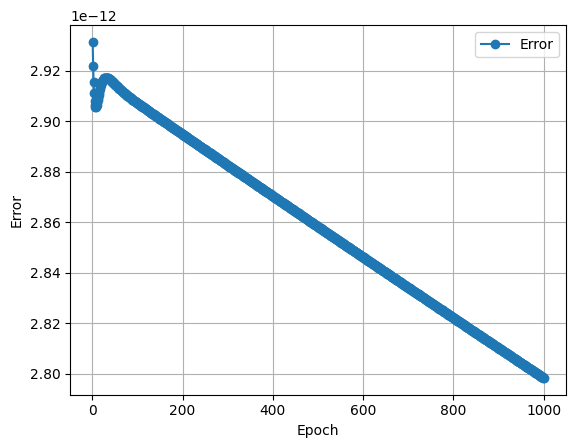

In [14]:
a = list(range(1,len(error_list_1)+1))

# Convergence
# for i in range(0, len(error_list_1)):

# plt.loglog(a, error_list_2, label = "",marker='o')
    
# error_list_convergence = jnp.array(error_list_1)
# error_list_convergence = jnp.log(error_list_convergence) / jnp.log(10)

# energy_error_list_convergence = jnp.array(error_list_3)
# energy_error_list_convergence = jnp.array(energy_error_list_convergence) / jnp.log(10)

# e_list_convergence = jnp.array(error_list_4)
# e_list_convergence = jnp.array(e_list_convergence) / jnp.log(10)

# validation_error_list = jnp.array(validation_error_list)
# validation_error_list = jnp.log(validation_error_list) / jnp.log(10)

# plt.plot(a, error_list_convergence, label = "Error",marker='o')
# plt.plot(a, validation_error_list,label = "Validation",marker='s' )
# plt.plot(a, energy_error_list_convergence,label = "Energy_Error",marker='s' )
# plt.plot(a, e_list_convergence,label = "E",marker='o' )


error_list_convergence = jnp.array(error_list_1)
error_list_convergence = jnp.log(error_list_convergence) / jnp.log(10)
plt.plot(a, error_list_1, label = "Error",marker='o')

plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Error')

Text(0, 0.5, 'Error')

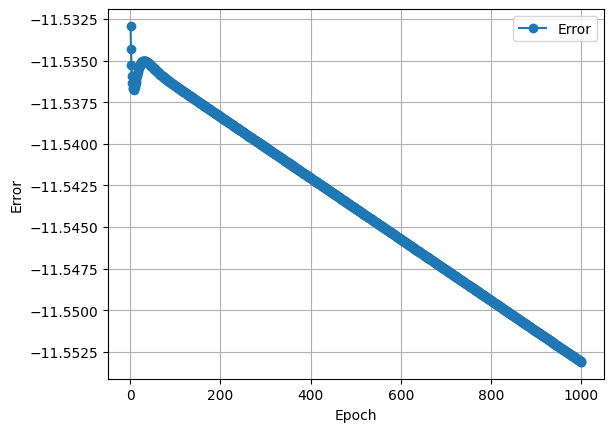

In [15]:

plt.plot(a, error_list_convergence, label = "Error",marker='o')

plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Error')

# Now applying the updated value to the PRK method, and checking the convergence, dynamic and contour plots

In [11]:
import json
import jax.numpy as jnp

# File path
file_path = 'Recorded_Results_SGD2/BatchOutput_SGD2.json'

# Reading the data from the JSON file
with open(file_path, 'r') as json_file:
    loaded_data = json.load(json_file)

# Converting the data back to jax.numpy
A1 = jnp.array(loaded_data['A1'])
A2 = jnp.array(loaded_data['A2'])
B1 = jnp.array(loaded_data['B1'])
B2 = jnp.array(loaded_data['B2'])

print("============")
print(A1)
print(B1)
print(A2)
print(B2)
print("============")

# print(A2)
# print(B2)

# A2 = jnp.array([
#      [1/6, -1/6, 0., 0.],
#      [1/6, 1/3, 0., 0.],
#      [1/6, 5/6, 0., 0.],
#      [0., 0., 0., 0.]])
# B2 = jnp.array([1/6, 2/3, 1/6, 0.])

# Lobatto IIIA fourth-order
# A1 = jnp.array([
#      [0., 0., 0., 0.],
#      [5/24, 1/3, -1/24, 0.],
#      [1/6, 2/3, 1/6, 0.],
#      [0., 0., 0., 0.]])
# B1 = jnp.array([1/6, 2/3, 1/6, 0.])

# Lobatto IIIB fourth-order
# A2 = jnp.array([
#      [1/6, -1/6, 0., 0.],
#      [1/6, 1/3, 0., 0.],
#      [1/6, 5/6, 0., 0.],
#      [0., 0., 0., 0.]])
# B2 = jnp.array([1/6, 2/3, 1/6, 0.])

# A1 = A2 = jnp.array([
#      [0., 0., 0., 0.],
#      [1/2, 0., 0., 0.],
#      [0., 1/2, 0., 0.],
#      [0., 0., 1.0, 0.]])


# B1 = B2 = jnp.array([1/6, 1/3, 1/3, 1/6])

@jit
def f(y, z):
    return z
@jit
def g(y, z):
    return -y

def Energy_Function(y, z):
    return (jnp.square(y) + jnp.square(z))/2

@jit
def PRK_step(y0 , z0, h, A1, A2, B1, B2):
    s = A1.shape[0]
    dim = jnp.size(y0)
    tol = 10**(-10)
    K_old = jnp.zeros((s,dim))
    L_old = jnp.zeros((s,dim))

    K_new = f((y0+ h*A1 @ K_old), (z0+ h*A2 @ L_old))
    L_new = g((y0+ h*A1 @ K_old), (z0+ h*A2 @ L_old))

    init_state = 0, K_new, L_new, K_old, L_old
    
    @jit
    def body_while_loop(state):
        _, K_new, L_new, K_old, L_old = state
        K_old = K_new
        L_old = L_new
        K_new = f(y0+ h * A1 @ K_old, z0 + h * A2 @ L_old)
        L_new = g(y0+ h * A1 @ K_old, z0 + h * A2 @ L_old)

        return _, K_new, L_new, K_old, L_old
    
    @jit
    def condition_while_loop(state):
        _, K_new, L_new, K_old, L_old = state
        norms = jnp.sum(jnp.array([jnp.linalg.norm(K_new - K_old) + jnp.linalg.norm(L_new - L_old)]))
        return norms > tol

    _, K_new, L_new, K_old, L_old = jax.lax.while_loop(condition_while_loop, body_while_loop, init_state)
    yn = y0 + h * B1 @ K_new
    zn = z0 + h * B2 @ L_new

    return yn, zn




if __name__ == "__main__":
    time_factor = 1 # default

    y0 = jnp.zeros((1,1))
    z0 = jnp.ones((1,1))

    NN = jnp.array([1, 10, 100, 1000])
    istep = 10
    step_size_list_convergence = []
    o_error_list_convergence = []
    c_error_list_convergence = []


    for i in range(len(NN)):
        yn_list = jnp.zeros((time_factor * NN[i], 1))
        zn_list = jnp.zeros((time_factor * NN[i], 1))
        iyn_list = jnp.zeros((time_factor * istep * NN[i] , 1))
        izn_list = jnp.zeros((time_factor * istep * NN[i] , 1))

        yn = zn = iyn = izn = []
        h = 1/NN[i] #step size
        y = iy = y0
        z = iz = z0
        def fori_loop_2(j, state):
            iyn_list, izn_list, iy, iz, A1, A2, B1, B2 = state
            iy, iz = PRK_step(iy, iz, h/istep, A1, A2, B1, B2)
            iyn_list = iyn_list.at[j].set(iy.ravel())
            izn_list = izn_list.at[j].set(iz.ravel())
            state = iyn_list, izn_list, iy, iz, A1, A2, B1, B2

            return state

        def fori_loop_1(i, state):
            yn_list, zn_list, y, z, A1, A2, B1, B2 = state
            y, z = PRK_step(y, z, h, A1, A2, B1, B2)
            yn_list = yn_list.at[i].set(y.ravel())
            zn_list = zn_list.at[i].set(z.ravel())
            state = yn_list, zn_list, y, z, A1, A2, B1, B2

            return state
        
        init_state_yz = yn_list, zn_list, y, z, A1, A2, B1, B2
        yn_list, zn_list, _, _, _, _, _, _ = jax.lax.fori_loop(0, time_factor * NN[i], fori_loop_1, init_state_yz)
        
        init_state_iyz = iyn_list, izn_list, iy, iz, A1, A2, B1, B2
        iyn_list, izn_list, _, _, _, _, _, _ = jax.lax.fori_loop(0, time_factor * istep * NN[i], fori_loop_2, init_state_iyz) # time istep
        j1_iyn_list = iyn_list[9:time_factor*istep*NN[i]:istep]
        j2_izn_list = izn_list[9:time_factor*istep*NN[i]:istep]

        # this is for calculating the original error
        tt1 =  jnp.linspace(h, 1, NN[i]*time_factor)
        sine_value = jnp.sin(tt1)
        cosine_value = jnp.cos(tt1)

        # Finding error using original Value
        err1 = yn_list.ravel() - sine_value #(yn_list, sine_value)
        err2 = zn_list.ravel() - cosine_value #(zn_list, cosine_value)

        original_error = jnp.sqrt((jnp.sum(jnp.square(err1))   ) / ( NN[i]))

        o_error_list_convergence.append(original_error)
        """   """
        # Finding error using original Value

        #### Calculating error with the smaller steps :
        print("======")
        print(j1_iyn_list.shape)
        print(yn_list.shape)
        print("======")

        err1 = j1_iyn_list.ravel() - yn_list.ravel()
        err2 = j2_izn_list.ravel() - zn_list.ravel()

        final_error = (jnp.sum(jnp.abs(err1)) + jnp.sum(jnp.abs(err2))) / (2*NN[i])

        #### Calculating error with the smaller steps :
        c_error_list_convergence.append(final_error)
        step_size_list_convergence.append(h)


[[ 1.13721604e-05  9.81499641e-06  8.22073795e-06  1.13705639e-05]
 [ 2.08380529e-01  3.33374448e-01 -4.16317757e-02  4.71908596e-05]
 [ 1.66679263e-01  6.66677779e-01  1.66676261e-01  1.25950340e-05]
 [ 4.52184472e-07  4.50716386e-07  4.47997034e-07  4.52184539e-07]]
[ 1.66588199e-01  6.66630964e-01  1.66673877e-01 -7.80340985e-05]
[[ 1.26700659e-05  1.18085622e-05  1.09155475e-05  1.26703403e-05]
 [ 2.08387979e-01  3.33384631e-01 -4.16188454e-02  5.46473987e-05]
 [ 1.66681697e-01  6.66680889e-01  1.66680047e-01  1.50308422e-05]
 [ 5.80878316e-07  5.86623708e-07  5.90742681e-07  5.80878064e-07]]
[ 1.66589900e-01  6.66624493e-01  1.66656232e-01 -7.64904283e-05]
(1, 1)
(1, 1)
(10, 1)
(10, 1)
(100, 1)
(100, 1)
(1000, 1)
(1000, 1)


In [38]:
# print(yn_list)

Text(0, 0.5, 'Log Error')

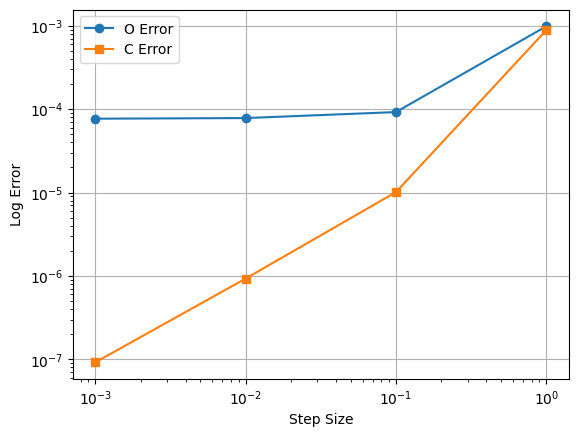

In [12]:
import matplotlib.pyplot as plt

# Convergence

# o_error_list_convergence = jnp.array(o_error_list_convergence)
# o_error_list_convergence = jnp.log(o_error_list_convergence) / jnp.log(10)
# c_error_list_convergence = jnp.array(c_error_list_convergence)
# c_error_list_convergence = jnp.log(c_error_list_convergence)/jnp.log(10)
# plt.plot(step_size_list_convergence, o_error_list_convergence, label = "Error",marker='o')
# plt.plot(step_size_list_convergence, c_error_list_convergence, label = "Error",marker='s')


plt.loglog(step_size_list_convergence, o_error_list_convergence, label = "O Error",marker='o')
plt.loglog(step_size_list_convergence, c_error_list_convergence, label = "C Error",marker='s')

plt.legend()
plt.grid()
plt.xlabel('Step Size')
plt.ylabel('Log Error')

1000


Text(0, 0.5, 'x')

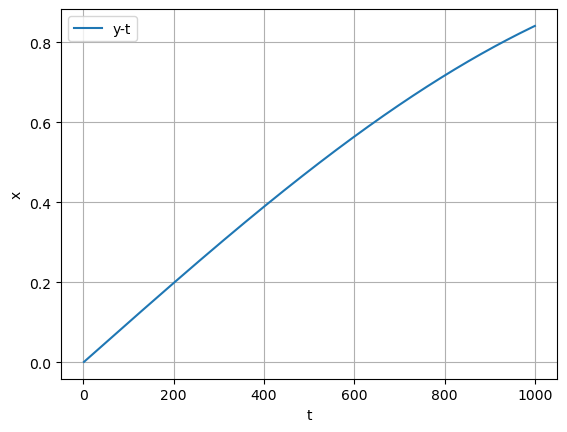

In [201]:
print(len(yn_list))
t2 = jnp.arange(1, 1001, 1)
plt.plot(t2, yn_list, label = "y-t", )
plt.legend()
plt.grid()
plt.xlabel('t')
plt.ylabel('x')
     

Text(0, 0.5, 'x')

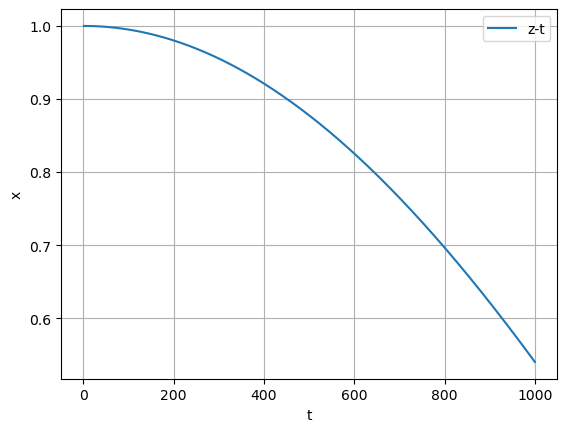

In [70]:
t2 = jnp.arange(1, 1001, 1)
plt.plot(t2, zn_list, label = "z-t", )
plt.legend()
plt.grid()
plt.xlabel('t')
plt.ylabel('x')

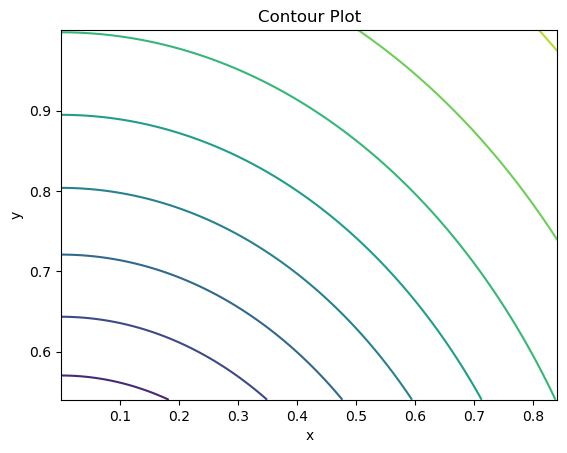

In [71]:
x = yn_list
x = x.flatten()
y = zn_list
y = y.flatten()
X, Y = jnp.meshgrid(x, y)
Z = jnp.sin(jnp.sqrt(X**2 + Y**2))

# Create the contour plot
plt.contour(X, Y, Z)
plt.title('Contour Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## energy Error :


In [39]:
C = jnp.zeros((len(yn_list)))

for i in trange(0, len(yn_list)):
    i_start = i *10
    i_end = i_start + 10
    C = C.at[i].set(jnp.sum((yn_list[i] - yn_list[0][i_start:i_end])**2))
    
print(C)

100%|██████████| 1000/1000 [00:02<00:00, 495.54it/s]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.